In [41]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm
import numpy as np
import seaborn as sns
import plotly.express as px
import pickle
from bertopic import BERTopic
import hdbscan

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.metrics import pairwise_distances

from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer

In [25]:
# Load the data
data = pickle.load(open('/content/data_preprocessed_classification.pkl', 'rb'))

# Convert to DataFrame
data = pd.DataFrame(data)

data = data[['meals']]
data = data[data['meals'].apply(lambda x: len(x) > 0)]
data['meals'] = data['meals'].apply(lambda meals: [meal.lower() for meal in meals])
data.reset_index(drop=True, inplace=True)
dish_mapping = {
    "biriyani": "biryani",
    "biryanis": "biryani",
    "veggie": "veg",
    "veggies": "veg",
    "non veg": "non-veg",
    "pizzas": "pizza",
    "burgers": "burger",
    "cakes":"cake",
    "beers": "beer",
    "soups":"soup",
    "kebabs":"kebab",
    "fries":"french fries",
    "shakes":"shake",
    "parathas":"paratha",
    "curries":"curry",
    "ice creams":"ice cream",
    "icecream":"ice cream",
    "babycorn":"baby corn",
    "brownies": "brownie"


}
data['meals'] = data['meals'].apply(lambda meals: [dish_mapping.get(dish, dish) for dish in meals])
all_words = [dish for meal_list in data['meals'] for dish in meal_list]

delete_list = [
    # Ingredients and non-dishes
    "chicken", "veg", "fish", "paneer", "coffee", "cheese", "spices",
    "gravy", "chocolate", "wings", "vegetables",
    "garlic", "onion", "meat", "egg", "oil", "salt", "water", "beer", "mocktails",
    "non-veg", "sauce", "cocktails", "rice", "corn", "potato", "fruits", "naan",
    "noodles", "cake", "ice cream", "soup", "starters", "pastries", "shake",
    "donuts", "bread", "masala", "sauces", "salad", "pork", "butter", "chicken pieces",
    "onions", "mushroom", "tea", "breads", "cupcakes", "salads", "waffles", "cream",
    "sandwich", "mayo", "mutton", "mint", "lamb", "broccoli", "coconut", "coconut milk"
    "mojito", "mango", "mocktail", "baby corn", "pepper", "cucumber", "potatoes",
    "mayonnaise", "lemon", "tomato", "cocktail", "herbs", "capsicum", "carrot", "coriander",
    "strawberry", "orange", "sandwiches", "dessert", "desserts", "pineapple", "mushrooms",
    "sweets", "spinach"


]
data['meals'] = data['meals'].apply(
    lambda meals: [dish for dish in meals if dish not in delete_list]
)
data.head()

,meals
0,[penne alfredo pasta]
1,"[kodi drumsticks, basket mutton biryani]"
2,"[tawa fish, basket biryani, biryani]"
3,[chili honey lotus stem]
4,[honey chilli lotus]


In [26]:
def cooccurrence_matrix_meals_generator(meals):

    co_occurrences = defaultdict(Counter)

    for meal_list in tqdm(meals):
        for dish1 in meal_list:
            for dish2 in meal_list:
                if dish1 != dish2:
                    co_occurrences[dish1][dish2] += 1


    unique_dishes = list(set(dish for meal_list in meals for dish in meal_list))


    co_matrix = np.zeros((len(unique_dishes), len(unique_dishes)), dtype=int)


    dish_index = {dish: idx for idx, dish in enumerate(unique_dishes)}
    for dish, neighbors in co_occurrences.items():
        for neighbor, count in neighbors.items():
            co_matrix[dish_index[dish]][dish_index[neighbor]] = count


    co_matrix_df = pd.DataFrame(co_matrix, index=unique_dishes, columns=unique_dishes)


    #sorted_indices = co_matrix_df.sum(axis=1).sort_values(ascending=False).index
    #co_matrix_df = co_matrix_df.loc[sorted_indices, sorted_indices]
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=1)
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=0)
    return co_matrix_df

# Generate the co-occurrence matrix
meals_co_occurrence = cooccurrence_matrix_meals_generator(data['meals'].tolist())

100%|██████████| 5904/5904 [00:00<00:00, 105907.89it/s]


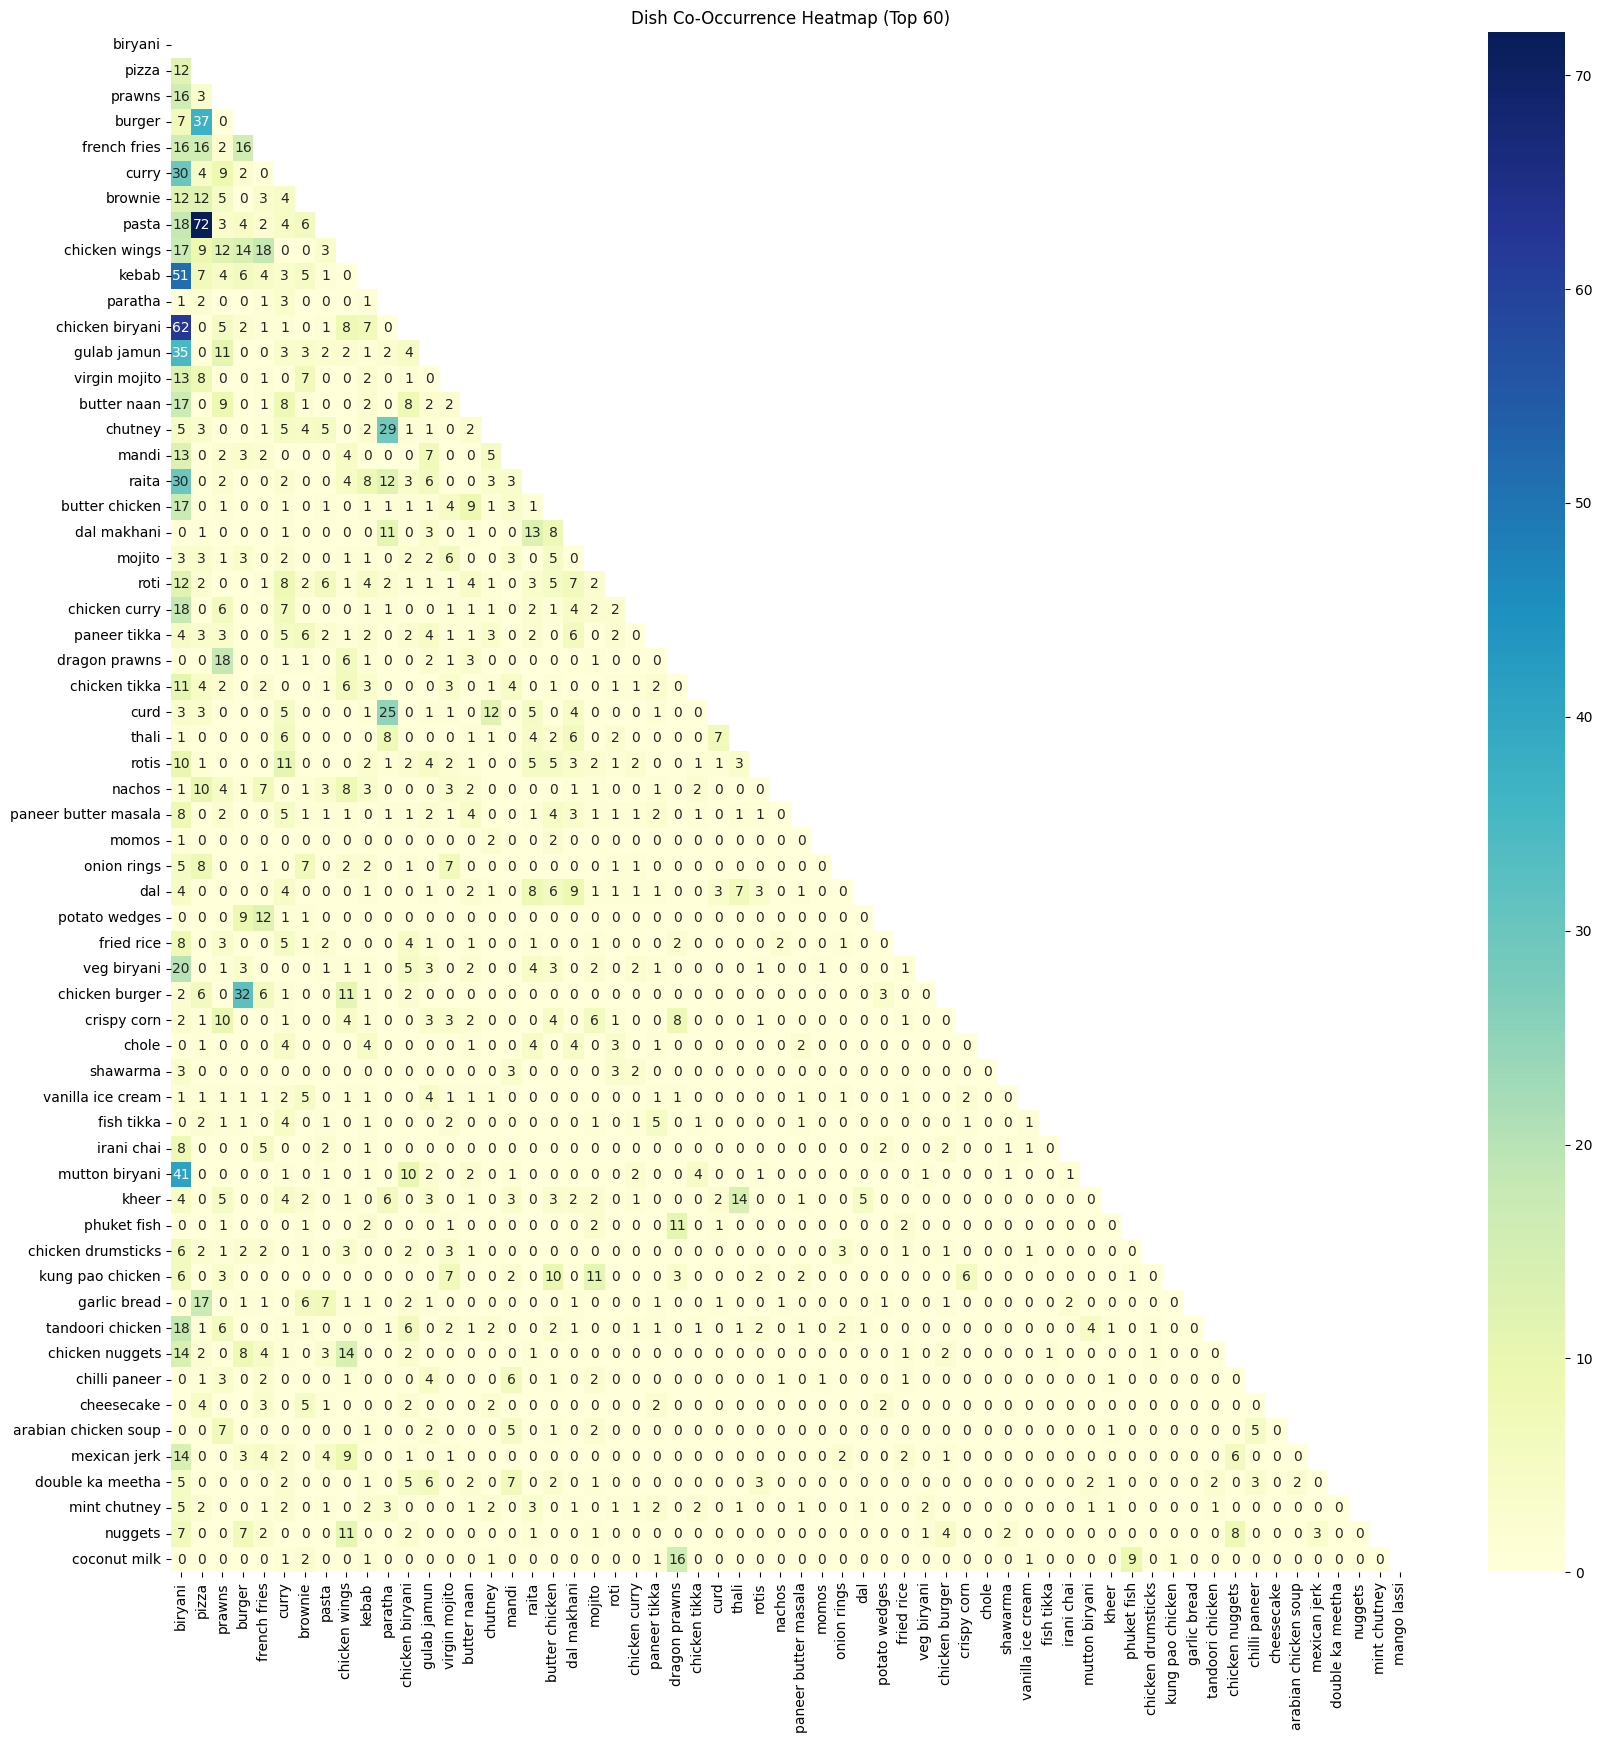

In [27]:
mask = np.triu(np.ones_like(meals_co_occurrence.iloc[:60, :60], dtype=bool))


plt.figure(figsize=(20, 20))
sns.heatmap(meals_co_occurrence.iloc[:60, :60], cmap="YlGnBu", mask=mask, annot=True, fmt="d")
plt.title("Dish Co-Occurrence Heatmap (Top 60)")
plt.show()

In [28]:
fig = px.imshow(meals_co_occurrence.iloc[:60, :60], color_continuous_scale='YlGnBu',
                labels=dict(x="Dish", y="Dish", color="Count"),
                title="Dish Co-occurrence (60 most frequent co-occurring words)",
                width=1200, height=1200)

fig.show()

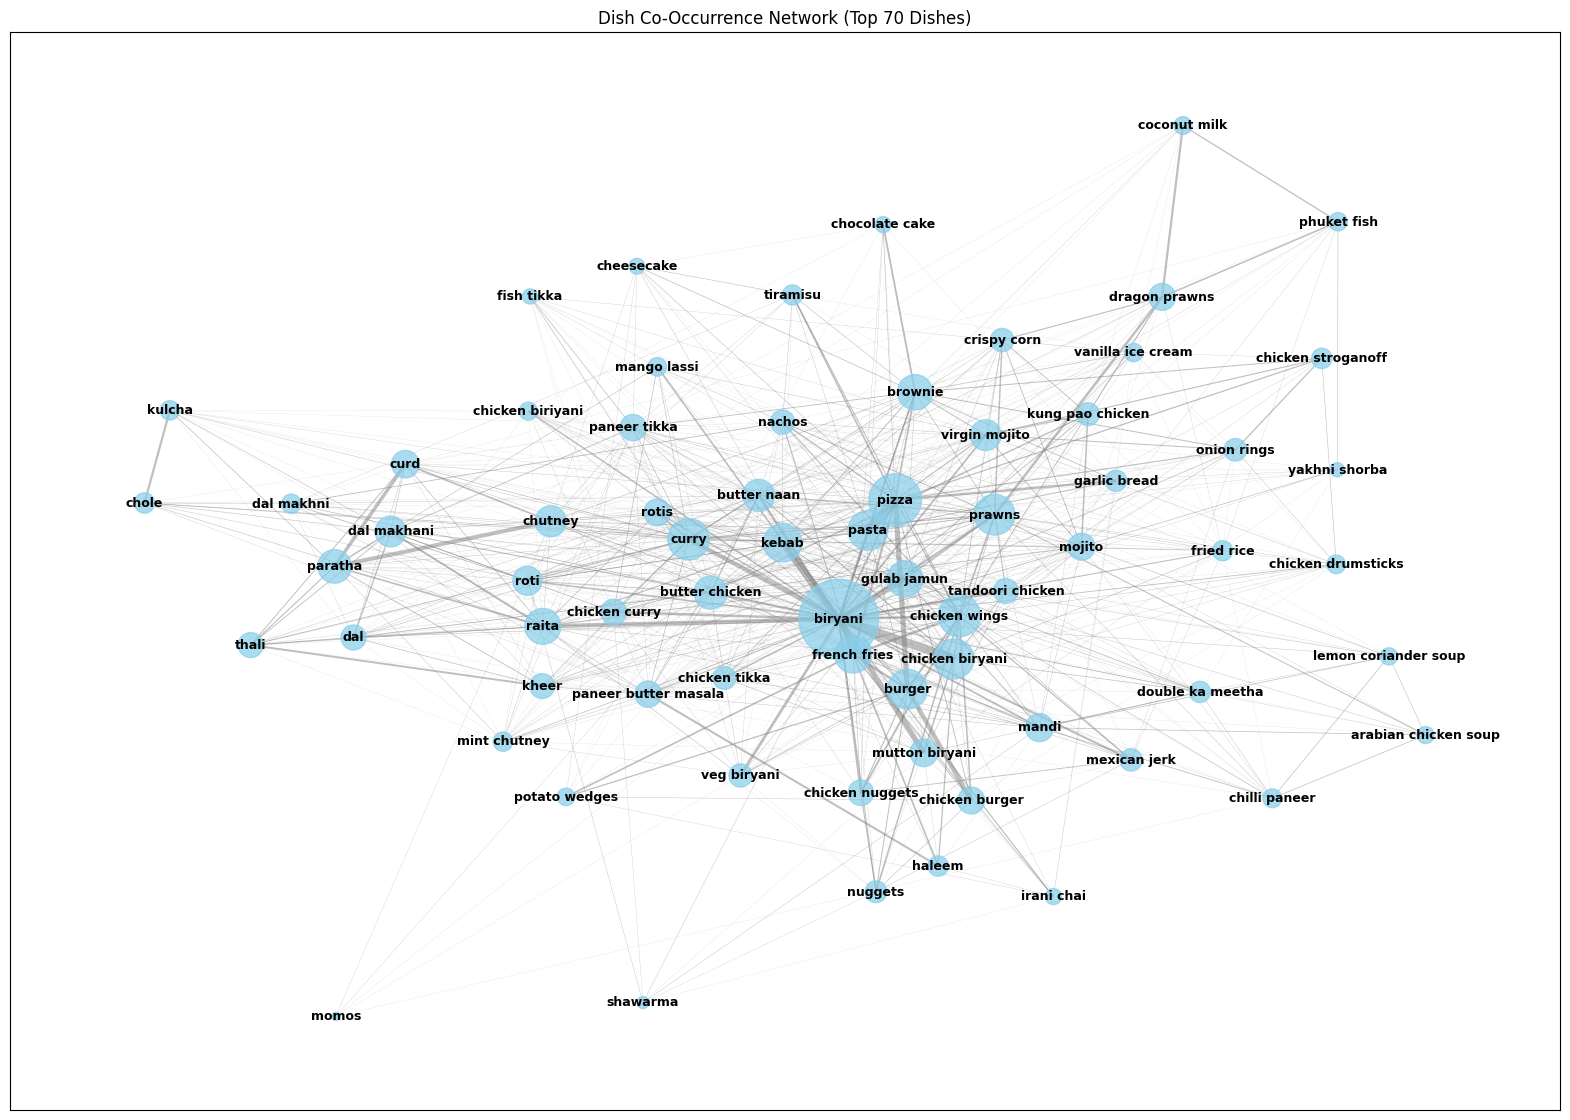

In [29]:
def cooccurrence_network_generator(cooccurrence_matrix_df, n_highest_dishes, output=None):

    filtered_df = cooccurrence_matrix_df.iloc[:n_highest_dishes, :n_highest_dishes]
    graph = nx.Graph()


    for dish in filtered_df.columns:
        graph.add_node(dish, size=filtered_df[dish].sum())


    for dish1 in filtered_df.columns:
        for dish2 in filtered_df.columns:
            if dish1 != dish2 and filtered_df.loc[dish1, dish2] > 0:
                graph.add_edge(dish1, dish2, weight=filtered_df.loc[dish1, dish2])



    pos = nx.spring_layout(graph, k=0.5)


    edge_weights = [0.1 * graph[u][v]['weight'] for u, v in graph.edges()]


    node_sizes = [data['size'] * 5 for _, data in graph.nodes(data=True)]

    # Create the network graph
    plt.figure(figsize=(20, 14))
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', width=edge_weights, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=9, font_weight='bold')

    plt.title(f"Dish Co-Occurrence Network (Top {n_highest_dishes} Dishes)")
    plt.show()


# Example usage with your co-occurrence matrix
cooccurrence_network_generator(meals_co_occurrence, 70)

# Clustering using HDBScan with precalculated distance matrices based on co-occurence

In [33]:
normalized_matrix = normalize(meals_co_occurrence, norm='l2', axis=1)

distance_matrix_cosine = cosine_distances(normalized_matrix)
distance_matrix_euclidean = euclidean_distances(normalized_matrix)
distance_matrix_pairwise = pairwise_distances(normalized_matrix, metric='jaccard')

In [35]:
# Perform clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=3, min_samples=1)

clusters_cosine = clusterer.fit_predict(distance_matrix_cosine)
clusters_euclidean = clusterer.fit_predict(distance_matrix_euclidean)
clusters_pairwise = clusterer.fit_predict(distance_matrix_pairwise)

# Calculate silhouette scores for each clustering
silhouette_scores = {
    'cosine': silhouette_score(distance_matrix_cosine, clusters_cosine, metric='precomputed'),
    'euclidean': silhouette_score(distance_matrix_euclidean, clusters_euclidean, metric='precomputed'),
    'pairwise': silhouette_score(distance_matrix_pairwise, clusters_pairwise, metric='precomputed')
}

# Print silhouette scores
for metric, score in silhouette_scores.items():
    print(f"Silhouette Score for {metric} clustering: {score}")

Silhouette Score for cosine clustering: 0.2722782540002152
Silhouette Score for euclidean clustering: 0.18379066996610116
Silhouette Score for pairwise clustering: 0.34236042192050825


In [36]:
# Organize words into their respective clusters
cluster_dict = {}
for word, cluster in zip(meals_co_occurrence.columns, clusters_pairwise):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = []
    cluster_dict[cluster].append(word)

# Print the clusters and their words
for cluster_id, cluster_words in cluster_dict.items():
    if cluster_id == -1:
        print(f"Cluster {cluster_id} (Noise/Outliers):")
    else:
        print(f"Cluster {cluster_id}:")
    print(", ".join(cluster_words))
    print("-" * 40)


Cluster -1 (Noise/Outliers):
biryani, pizza, prawns, burger, french fries, curry, brownie, pasta, chicken wings, kebab, chicken biryani, gulab jamun, virgin mojito, butter naan, chutney, mandi, raita, butter chicken, dal makhani, mojito, roti, chicken curry, paneer tikka, dragon prawns, chicken tikka, rotis, nachos, momos, onion rings, dal, potato wedges, fried rice, veg biryani, chicken burger, crispy corn, chole, shawarma, vanilla ice cream, fish tikka, irani chai, kheer, phuket fish, chicken drumsticks, kung pao chicken, garlic bread, tandoori chicken, chicken nuggets, chilli paneer, cheesecake, arabian chicken soup, nuggets, lemon coriander soup, chicken stroganoff, yakhni shorba, kulcha, haleem, chocolate cake, dal makhni, chicken biriyani, butter garlic prawns, bangla kodi, sushi, chicken mandi, bruschetta, lemonade, chole bhature, omelette, caramel, tomatoes, chicken popcorn, dragon chicken, ginger, sugar, manchow soup, gin, cardamom, tandoor, prawn, pork ribs, basmati rice, tik

# BERTopic Clustering using pretrained embeddings




In [37]:
documents = list(meals_co_occurrence.columns)

# Parameter grid for HDBSCAN
min_cluster_sizes = [5, 10, 20, 30]
min_samples_list = [1, 5, 10]

best_score = -1
best_model = None
best_params = {}

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        # Initialize a custom HDBSCAN model with the current parameters
        custom_hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                         min_samples=min_samples)

        # Initialize BERTopic with the custom HDBSCAN model
        topic_model = BERTopic(hdbscan_model=custom_hdbscan)

        # Fit and transform the documents
        topics, probs = topic_model.fit_transform(documents)

        embeddings = topic_model._extract_embeddings(documents)

        # Convert topics to a NumPy array
        labels = np.array(topics)

        # Exclude noise points with cluster label -1
        mask = labels != -1
        if mask.sum() > 1:  # Ensure there's more than one data point after filtering out noise
            score = silhouette_score(embeddings[mask], labels[mask])

            # Check if this is the best silhouette score so far
            if score > best_score:
                best_score = score
                best_model = topic_model
                best_params = {
                    "min_cluster_size": min_cluster_size,
                    "min_samples": min_samples
                }

print("Best HDBSCAN Parameters:", best_params)
print("Best Silhouette Score:", best_score)

Best HDBSCAN Parameters: {'min_cluster_size': 5, 'min_samples': 5}
Best Silhouette Score: 0.10369135


In [38]:
custom_hdbscan = hdbscan.HDBSCAN(**best_params)
topic_model = BERTopic(hdbscan_model=custom_hdbscan)

# Fit and transform the documents
topics, probs = topic_model.fit_transform(documents)


topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1410,-1_basil_shorba_cheesecake_pad,"[basil, shorba, cheesecake, pad, blueberry, me...","[chilly basil prawns, chilli basil prawns, bas..."
1,0,82,0_burger_burgers_patty_lucy,"[burger, burgers, patty, lucy, patties, milky,...","[chicken burger, burger, burger 🍔]"
2,1,66,1_pasta_penne_alfredo_spaghetti,"[pasta, penne, alfredo, spaghetti, pink, white...","[veg penne alfredo pasta, penne alfredo pasta,..."
3,2,64,2_cake_cakes_cup_lava,"[cake, cakes, cup, lava, sponge, chocolate, ca...","[chocolate cup cakes, cheese cake, chocolate c..."
4,3,64,3_kfc_thread_jamaican_buffalo,"[kfc, thread, jamaican, buffalo, jerk, honey, ...","[jamaican jerk chicken, kfc, kfc chicken]"
...,...,...,...,...,...
347,346,5,346_noodles_veggie_soft_nonveg,"[noodles, veggie, soft, nonveg, mixed, veg, , ...","[veggie noodles, veg noodles veg noodles, veg ..."
348,347,5,347_thighs_legs_bones_bone,"[thighs, legs, bones, bone, leg, chicken, , , , ]","[chicken bones, chicken thighs, chicken legs]"
349,348,5,348_uke_ine_aste_ane,"[uke, ine, aste, ane, pice, , , , , ]","[ine, aste, ane]"
350,349,5,349_kachoris_navratan_kurma_kasmiri,"[kachoris, navratan, kurma, kasmiri, kachori, ...","[kasmiri naan, navratan kurma, kachoris]"


In [61]:
cuisine_labels =  ['American', 'Andhra', 'Arabian', 'Asian', 'BBQ', 'Bakery',
       'Beverages', 'Biryani', 'Burger', 'Cafe', 'Chinese', 'Continental',
       'Desserts', 'European', 'Fast Food', 'Finger Food', 'Goan',
       'Healthy Food', 'Hyderabadi', 'Ice Cream', 'Indonesian', 'Italian',
       'Japanese', 'Juices', 'Kebab', 'Lebanese', 'Mediterranean',
       'Mexican', 'Modern Indian', 'Momos', 'Mughlai', 'North Eastern',
       'North Indian', 'Pizza', 'Salad', 'Seafood', 'South Indian',
       'Spanish', 'Street Food', 'Sushi', 'Thai', 'Wraps']

# Extract top words for each topic
all_topics = topic_model.get_topic_info()
topic_ids = all_topics.Topic.unique().tolist()

# Embed both the cuisine labels and the topic keywords
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the cuisine labels
cuisine_embeddings = model.encode(cuisine_labels, convert_to_numpy=True, normalize_embeddings=True)

# Prepare an array to store the best cuisine label for each topic
best_labels = []

for topic_id in topic_ids:
    if topic_id == -1:
        # Skip the outlier topic
        best_labels.append("Outlier/Noise")
        continue

    # Get the top words for this topic
    topic_words = topic_model.get_topic(topic_id)
    # topic_words is a list of tuples (word, score), we just take the words
    words = [word for word, _ in topic_words]

    # Join top words into a descriptive phrase or just take a few top words
    topic_description = " ".join(words[:5])  # for instance, top 5 words

    # Encode the topic description
    topic_embedding = model.encode([topic_description], convert_to_numpy=True, normalize_embeddings=True)

    # Compute cosine similarities
    similarities = np.dot(cuisine_embeddings, topic_embedding.T).squeeze()
    # Find the cuisine label with the highest similarity
    best_label = cuisine_labels[np.argmax(similarities)]
    best_labels.append(best_label)

# Now assign the best labels to the topics
topic_model.set_topic_labels(best_labels)

In [58]:
fig = topic_model.visualize_barchart(custom_labels=best_labels, top_n_topics=16)
fig.show()